In [183]:
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
def fn(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1]
    else:
        return array[idx]
def gen(x):
    if min(x['dis_t'],x['dis_s'])>5000:
        return ''
    else:
        if x['dis_t']<=x['dis_s']:
            return x['gen_t']
        else:
            return x['gen_s']

In [6]:
%%time
wb=pd.read_csv('data/array/GSE132203_Geo_Submission_GTPEpic.csv',nrows=1000000,usecols=[0]+list(range(1,1591,2)),index_col=0).round(3)

CPU times: user 3min 2s, sys: 11.7 s, total: 3min 14s
Wall time: 3min 14s


In [7]:
age=pd.read_table('https://ftp.ncbi.nlm.nih.gov/geo/series/GSE132nnn/GSE132203/matrix/GSE132203_series_matrix.txt.gz',skiprows=29+10,nrows=0,index_col=0).columns.str.strip('age: ').astype(float)

In [8]:
%%time 
wb_t=wb.T
wb_t['age']=age
wb_cor=wb_t.corrwith(wb_t['age']).drop('age').sort_values()

CPU times: user 3min 34s, sys: 129 ms, total: 3min 34s
Wall time: 3min 34s


In [9]:
man=pd.read_table('../Blood-DNA-Methylation-Atlas/data/ref/EPIC.hg38.manifest.tsv',index_col='Probe_ID')[['CpG_chrm','CpG_beg']]
man=man.dropna().copy()
man['CpG_beg']=man['CpG_beg'].astype(int)
man.columns=[0,1]
man=man[man[0].isin('chr'+str(c) for c in range(1,23))].copy()
#man['cg']=man.index

In [10]:
man=man.merge(wb_cor.rename('cor'),left_index=True,right_index=True)
man['pos']=man[0].str[3:].astype(int)*10**9+man[1]
man=man.sort_values('pos')
man.shape
#man['bin']=man['cor']>0

(800192, 4)

In [11]:
%%time
hmr=pd.read_table('/labs/mpsnyder/moqri/epi_deconv/data/arc/hmr/neo',header=None,index_col=3,usecols=[0,1,2,3])
hmr['b']=hmr[0].str[3:].astype(int)*10**9+hmr[1]
hmr['e']=hmr[0].str[3:].astype(int)*10**9+hmr[2]
hmr=hmr.sort_values('b')
l=[]
cur=0
for i,b in man.iterrows():
    if cur>=len(hmr):
        l.append(0)
    else: 
        pos=b['pos']
        cg=b.name
        b=hmr['b'].iloc[cur]
        e=hmr['e'].iloc[cur]        
        if pos<b:
            l.append(0)
        if pos>=b and pos<=e:
            l.append(cur)
        if pos>e:
            while (pos>hmr['e'].iloc[cur] and cur<len(hmr)-1):
                cur+=1
                b=hmr['b'].iloc[cur]
                e=hmr['e'].iloc[cur] 
            if pos>=b and pos<=e:
                l.append(cur)
            else:
                l.append(0)
man['hmr']=l
man['hmr_bin']=man['hmr'].clip(upper=1)

CPU times: user 1min 20s, sys: 245 ms, total: 1min 20s
Wall time: 1min 20s


In [12]:
cor450=pd.read_csv('data/res/cor450.csv',index_col=0)
man=man.merge(cor450,left_index=True, right_index=True,how='left')

In [13]:
cg=wb_cor[wb_cor>.0917].head(1).index[0]
pearsonr(wb_t[cg],wb_t['age'])

PearsonRResult(statistic=0.09170011703738634, pvalue=0.009683327216200192)

In [14]:
pv=.0917

In [15]:
%%time 
contp=[]
c=1000000
last=False
last_l=-1
last_pos=man[1].head(1).values[0]
for i,b in man[[1,'cor']].iterrows():
    if b[1]-last_pos>1000:
        c+=1
    if b['cor']>pv:
        if last==False:
            c+=1
        last=True  
        contp.append(c)
    else:
        contp.append(-1)
        last=False
    last_pos=b[1]

CPU times: user 52.6 s, sys: 105 ms, total: 52.7 s
Wall time: 52.7 s


In [16]:
%%time 
contn=[]
c=2000000
last=False
last_l=-1
last_pos=man[1].head(1).values[0]
for i,b in man[[1,'cor']].iterrows():
    if b[1]-last_pos>1000:
        c+=1
    if b['cor']<-pv:
        if last==False:
            c+=1
        last=True  
        contn.append(c)
    else:
        contn.append(-1)
        last=False
    last_pos=b[1]

CPU times: user 52.9 s, sys: 196 ms, total: 53.1 s
Wall time: 53.1 s


In [17]:
man['contp']=contp
man['contn']=contn

In [18]:
man.to_csv('data/res/epicor.csv')
#man=pd.read_csv('data/res/epicor.csv',index_col=0)

In [19]:
mgc=pd.DataFrame(man.groupby('contp')[0].count())
mgc['chr']=man.groupby('contp')[0].first()
mgc['b']=man.groupby('contp')[1].first()
mgc['e']=man.groupby('contp')[1].last()
mgc['cor']=man.groupby('contp')['cor'].mean()
mgc['cor450']=man.groupby('contp')['cor_450'].mean()
mgc['hmr']=man.groupby('contp')['hmr_bin'].mean()
topp=mgc[mgc[0]>=3].sort_values('cor',ascending=False)
topp.head(5)

,0,chr,b,e,cor,cor450,hmr
contp,,,,,,,
1049023,3,chr2,105399281,105399309,0.717583,0.825327,1.000000
1072766,9,chr3,51706605,51707456,0.539097,0.723285,0.888889
1288581,4,chr15,72319783,72319879,0.526374,0.523217,1.000000
1032067,3,chr1,228212515,228212926,0.515130,0.589686,1.000000
1132279,3,chr6,27631361,27631395,0.497728,0.639231,1.000000


In [20]:
mgc=pd.DataFrame(man.groupby('contn')[0].count())
mgc['chr']=man.groupby('contn')[0].first()
mgc['b']=man.groupby('contn')[1].first()
mgc['e']=man.groupby('contn')[1].last()
mgc['cor']=man.groupby('contn')['cor'].mean()
mgc['hmr']=man.groupby('contp')['hmr_bin'].mean()
mgc['hmr']=mgc['hmr'].fillna(0)
mgc['cor450']=man.groupby('contn')['cor_450'].mean()
topn=mgc[mgc[0]>=3].sort_values('cor')
topn.head(5)

,0,chr,b,e,cor,hmr,cor450
contn,,,,,,,
2364160,4,chr19,15419794,15420058,-0.492347,0.0,-0.510260
2154263,6,chr6,110415218,110415849,-0.440743,0.0,-0.389990
2006430,3,chr1,22642498,22642846,-0.432295,0.0,-0.198782
2145942,3,chr6,33162210,33162256,-0.419197,0.0,-0.478346
2096629,4,chr3,194270717,194271566,-0.413187,0.0,-0.564411


<Axes: xlabel='dir', ylabel='0'>

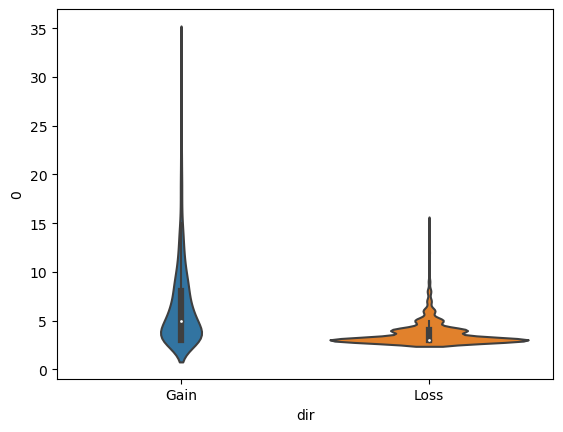

In [67]:
topp['dir']='Gain'
topn['dir']='Loss'
pl=pd.concat([topp.head(1000),topn.head(1000)])
sns.violinplot(data=pl[[0,'dir']],x='dir',y=0)

In [68]:
pl['rank']=pl['cor'].abs()
pl=pl.sort_values('rank',ascending=False).head(1000).copy()
pl=pl.drop('rank',axis=1)
pl.index=range(1,1001)

array([[<Axes: title={'center': 'cor450'}>]], dtype=object)

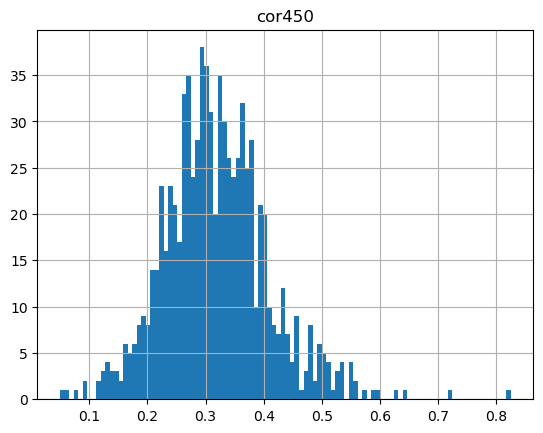

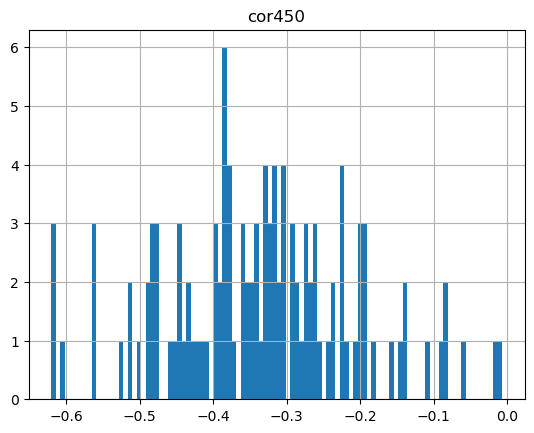

In [69]:
pl[pl['dir']=='Gain'].hist('cor450',bins=100)
pl[pl['dir']=='Loss'].hist('cor450',bins=100)

In [70]:
pl['hmr']=(pl['hmr']>0)

In [71]:
pg=pl.groupby(['dir','hmr'])['cor'].count()

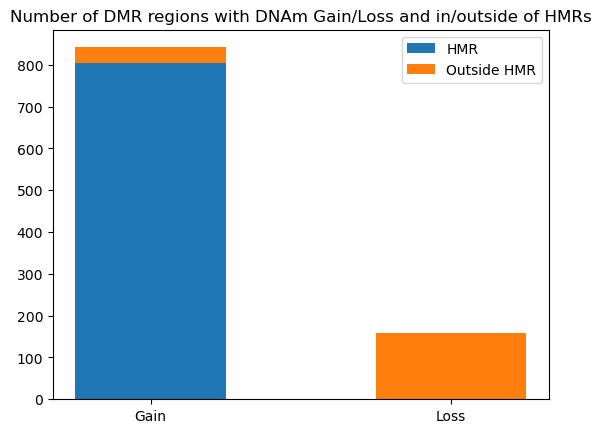

In [109]:
direc = (
    "Gain",
    "Loss",
)
counts = {
    "HMR": np.array([pg.loc[('Gain', True)],0]),
    "Outside HMR": np.array([pg.loc[('Gain', False)],pg.loc[('Loss', False)]]),
}
width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(2)

for boolean, c in counts.items():
    p = ax.bar(direc, c, width, label=boolean, bottom=bottom)
    bottom += c

ax.set_title("Number of DMR regions with DNAm Gain/Loss and in/outside of HMRs")
ax.legend(loc="upper right")

plt.show()

In [110]:
pl['s']=pl['chr'].str[3:].astype(int)*10**9+pl['b']
pl['t']=pl['chr'].str[3:].astype(int)*10**9+pl['e']

In [163]:
genc=pd.read_table('data/ref/gencode.txt',index_col=0)
genc.columns=range(1,6)
genc=genc[genc[1].isin(['chr'+str(c) for c in range(1,23)])].copy()
genc['tss']=genc.apply(lambda x: int(x[1][3:])*10**9+x[3] if x[2]=='+' else int(x[1][3:])*10**9+x[4],axis=1)
genc['tts']=genc.apply(lambda x: int(x[1][3:])*10**9+x[4] if x[2]=='+' else int(x[1][3:])*10**9+x[3],axis=1)
genc=genc[genc[5].str[:4]!='ENSG'].copy()
genc=genc[genc[5].str[:4]!='LINC'].copy()
genc=genc[genc[5].str[:3]!='MIR'].copy()
genc=genc[genc[5].str[:3]!='RPL'].copy()
genc=genc[genc[5].str[-3:]!='-DT'].copy()
genc=genc[genc[5].str[-4:-1]!='-AS'].copy()
ts={}
ts['s']=genc[[5,'tss']].drop_duplicates().groupby('tss')[5].apply(min)
ts['t']=genc[[5,'tts']].drop_duplicates().groupby('tts')[5].apply(min)

In [164]:
%%time
dis={}
gen={}
for typ in ['s','t']:
    dis[typ]=[]
    gen[typ]=[]
    for i,b in pl[['s','t']].iterrows():
        fns=fn(ts[typ].index,b['s'])
        fnt=fn(ts[typ].index,b['t'])    
        if b['s']<fns<b['t']:
            dis[typ].append(0)
            gen[typ].append(ts[typ].loc[fns])        
        elif b['s']<fnt<b['t']:
            dis[typ].append(0)   
            gen[typ].append(ts[typ].loc[fnt])        
        elif np.abs(b['s']-fns)<=np.abs(b['t']-fnt):
            dis[typ].append(np.abs(b['s']-fns))
            gen[typ].append(ts[typ].loc[fns])
        else:
            dis[typ].append(np.abs(b['t']-fnt))
            gen[typ].append(ts[typ].loc[fnt])

CPU times: user 477 ms, sys: 24.1 ms, total: 501 ms
Wall time: 470 ms


In [165]:
pl['dis_s']=dis['s']
pl['gen_s']=gen['s']
pl['dis_t']=dis['t']
pl['gen_t']=gen['t']

In [ ]:
pl['Gene']=pl.apply(lambda x: gen(x),axis=1)

In [184]:
plpr=pl.drop(['s','t'],axis=1).copy()

In [185]:
plpr.columns=['Number of CpGs','Chr','DMR Start','DMR End','Corr (Epic)','Corr (450k)', 
            'HMR','Gain or Loss','Distance to TSS','Nearest TSS','Distance to TTS','Nearest TTS','Gene']
plpr[['Gene','Nearest TSS','Distance to TSS','Nearest TTS','Distance to TTS','Number of CpGs','Chr','DMR Start','DMR End','Corr (Epic)','Corr (450k)', 
            'HMR','Gain or Loss']].round(2).to_csv('data/res/genes.csv')